#`python-control` Example: Vertical takeoff and landing aircraft

http://www.cds.caltech.edu/~murray/wiki/index.php/Python-control/Example:_Vertical_takeoff_and_landing_aircraft

This page demonstrates the use of the python-control package for analysis and design of a controller for a vectored thrust aircraft model that is used as a running example through the text *Feedback Systems* by Astrom and Murray. This example makes use of MATLAB compatible commands. 

##System Description
This example uses a simplified model for a (planar) vertical takeoff and landing aircraft (PVTOL), as shown below:
<img src=http://www.cds.caltech.edu/~murray/wiki/images/7/7d/Pvtol-diagram.png>  
<img src=http://www.cds.caltech.edu/~murray/wiki/images/b/b7/Pvtol-dynamics.png>
The position and orientation of the center of mass of the aircraft is denoted by $(x,y,\theta)$,  $m$ is the mass of the vehicle, $J$ the moment of inertia, $g$ the gravitational constant and $c$ the damping coefficient. The forces generated by the main downward thruster and the maneuvering thrusters are modeled as a pair of forces $F_1$ and $F_2$ acting at a distance $r$ below the aircraft (determined by the geometry of the thrusters).

It is convenient to redefine the inputs so that the origin is an equilibrium point of the system with zero input. Letting $u_1 =
F_1$ and $u_2 = F_2 - mg$, the equations can be written in state space form as:
<img src=http://www.cds.caltech.edu/~murray/wiki/images/2/21/Pvtol-statespace.png>

##LQR state feedback controller
This section demonstrates the design of an LQR state feedback controller for the vectored thrust aircraft example. This example is pulled from Chapter 6 (State Feedback) of [http:www.cds.caltech.edu/~murray/amwiki Astrom and Murray]. The python code listed here are contained the the file pvtol-lqr.py.

To execute this example, we first import the libraries for SciPy, MATLAB plotting and the python-control package:

In [2]:
from numpy import *             # Grab all of the NumPy functions
from matplotlib.pyplot import * # Grab MATLAB plotting functions
from control.matlab import *    # MATLAB-like functions
%matplotlib inline

The parameters for the system are given by

In [3]:
m = 4                         # mass of aircraft
J = 0.0475                    # inertia around pitch axis
r = 0.25                      # distance to center of force
g = 9.8                       # gravitational constant
c = 0.05                      # damping factor (estimated)
print("m = {}".format(m))
print("J = {}".format(J))
print("r = {}".format(r))
print("g = {}".format(g))
print("c = {}".format(c))

m = 4
J = 0.0475
r = 0.25
g = 9.8
c = 0.05


The linearization of the dynamics near the equilibrium point $x_e = (0, 0, 0, 0, 0, 0)$, $u_e = (0, mg)$ are given by

In [4]:
# State space dynamics
xe = [0, 0, 0, 0, 0, 0]        # equilibrium point of interest
ue = [0, m * g]                # (note these are lists, not matrices)

In [5]:
# Dynamics matrix (use matrix type so that * works for multiplication)
F1 = ue[0]
F2 = ue[1]
st = sin(xe[2])
ct = cos(xe[2])
A = matrix(
   [[ 0,    0,    0,    1,    0,    0],
    [ 0,    0,    0,    0,    1,    0],
    [ 0,    0,    0,    0,    0,    1],
    [ 0, 0, ((-F1 * st) - F2 * ct) / m, -c / m, 0, 0],
    [ 0, 0, ((F1 * ct) - F2 * st) / m, 0, -c / m, 0],
    [ 0,    0,    0,    0,    0,    0 ]])

# Input matrix
B = matrix(
   [[0, 0], 
    [0, 0], 
    [0, 0],
    [ct / m, -st / m],
    [st / m,  ct / m],
    [r / J, 0]])

# Output matrix 
C = matrix([[1, 0, 0, 0, 0, 0], 
           [0, 1, 0, 0, 0, 0]])
D = matrix([[0, 0], 
           [0, 0]])

To compute a linear quadratic regulator for the system, we write the cost function as
<img src=http://www.cds.caltech.edu/~murray/wiki/images/e/e1/Pvtol-lqrcost.png>

where $z = x - x_e$ and $v = u - u_e$ represent the local coordinates around the desired equilibrium point $(z_e, u_e)$. We begin with diagonal matrices for the state and input costs:

In [6]:
Qz1 = diag([1, 1, 1, 1, 1, 1])
Qv1a = diag([1, 1])
(K, X, E) = lqr(A, B, Qz1, Qv1a) 
K1a = array(K)

This gives a control law of the form $v = -K z$, which can then be used to derive the control law in terms of the original variables:


  $$u = v + u_d = - K(z - z_d) + u_d.$$
where $u_d = (0, mg)$ and $z_d = (x_d, y_d, 0, 0, 0, 0)$

Since the `python-control` package only supports SISO systems, in order to compute the closed loop dynamics, we must extract the dynamics for the lateral and altitude dynamics as individual systems. In addition, we simulate the closed loop dynamics using the step command with $K x_d$ as the input vector (assumes that the "input" is unit size, with $xd$ corresponding to the desired steady state. The following code performs these operations:

In [7]:
xd = array([[1], [0], [0], [0], [0], [0]])
yd = array([[0], [1], [0], [0], [0], [0]]) 

In [11]:
# Indices for the parts of the state that we want
lat = (0, 2, 3, 5)
alt = (1, 4)

# Decoupled dynamics
Ax = (A[lat, :])[:, lat]
Bx = B[lat, 0]
Cx = C[0, lat]
Dx = D[0, 0]
 
Ay = A[alt, :][:, alt]
By = B[alt, 1]
Cy = C[1, alt]
Dy = D[1, 1]

# Step response for the first input
H1ax = ss(Ax - Bx * K1a[0, lat], 
          Bx * K1a[0, lat] * xd[lat, :], 
          Cx, 
          Dx)
(Tx, Yx) = step(H1ax, T=linspace(0, 10, 100))

# Step response for the second input
H1ay = ss(Ay - By * K1a[1, alt], 
          By * K1a[1, alt] * yd[alt, :], 
          Cy, 
          Dy)
(Ty, Yy) = step(H1ay, T=linspace(0, 10, 100))

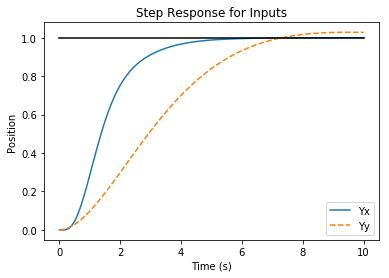

In [13]:
plot(Yx.T, Tx, '-', Yy.T, Ty, '--')
plot([0, 10], [1, 1], 'k-')
ylabel('Position')
xlabel('Time (s)')
title('Step Response for Inputs')
legend(('Yx', 'Yy'), loc='lower right')

The plot above shows the $x$ and $y$ positions of the aircraft when it is commanded to move 1 m in each direction. The following shows the $x$ motion for control weights $\rho = 1, 10^2, 10^4$. A higher weight of the input term in the cost function causes a more sluggish response. It is created using the code:

In [15]:
# Look at different input weightings
Qv1a = diag([1, 1])
(K1a, X, E) = lqr(A, B, Qz1, Qv1a)
H1ax = ss(Ax - Bx * K1a[0, lat], 
          Bx * K1a[0, lat] * xd[lat, :], 
          Cx, 
          Dx)

Qv1b = (40 ** 2) * diag([1, 1])
(K1b, X, E) = lqr(A, B, Qz1, Qv1b)
H1bx = ss(Ax - Bx * K1b[0, lat], 
          Bx * K1b[0, lat] * xd[lat, :], 
          Cx, 
          Dx)

Qv1c = (200 ** 2) * diag([1, 1]) 
(K1c, X, E) = lqr(A, B, Qz1, Qv1c)
H1cx = ss(Ax - Bx * K1c[0, lat], 
          Bx * K1c[0, lat] * xd[lat, :],
          Cx, 
          Dx)

[T1, Y1] = step(H1ax, T=linspace(0, 10, 100))
[T2, Y2] = step(H1bx, T=linspace(0, 10, 100))
[T3, Y3] = step(H1cx, T=linspace(0, 10, 100))

[0, 10, -0.1, 1.4]

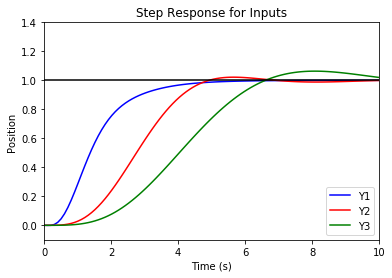

In [16]:
plot(Y1.T, T1, 'b-')
plot(Y2.T, T2, 'r-')
plot(Y3.T, T3, 'g-')
plot([0 ,10], [1, 1], 'k-')
title('Step Response for Inputs')
ylabel('Position')
xlabel('Time (s)')
legend(('Y1', 'Y2', 'Y3'), loc='lower right')
axis([0, 10, -0.1, 1.4])

##Lateral control using inner/outer loop design
This section demonstrates the design of loop shaping controller for the vectored thrust aircraft example. This example is pulled from Chapter 11 [Frequency Domain Design](http:www.cds.caltech.edu/~murray/amwiki) of Astrom and Murray. 

To design a controller for the lateral dynamics of the vectored thrust aircraft, we make use of a "inner/outer" loop design methodology. We begin by representing the dynamics using the block diagram.

<img src=http://www.cds.caltech.edu/~murray/wiki/images/3/3f/Pvtol-lateraltf.png>
where
<img src=http://www.cds.caltech.edu/~murray/wiki/images/math/3/6/4/364e56f7893637e12edb0e0ac6c45722.png>  
The controller is constructed by splitting the process dynamics and controller into two components: an inner loop consisting of the roll dynamics $P_i$ and control $C_i$ and an outer loop consisting of the lateral position dynamics $P_o$ and controller $C_o$.
<img src=http://www.cds.caltech.edu/~murray/wiki/images/f/f1/Pvtol-nested-1.png>
The closed inner loop dynamics $H_i$ control the roll angle of the aircraft using the vectored thrust while the outer loop controller $C_o$ commands the roll angle to regulate the lateral position.

The following code imports the libraries that are required and defines the dynamics:

### Transfer functions for dynamics

In [17]:
Pi = tf([r], [J, 0, 0])       # inner loop (roll)
Po = tf([1], [m, c, 0])       # outer loop (position)

For the inner loop, use a lead compensator.

In [18]:
k = 200
a = 2
b = 50
Ci = k * tf([1, a], [1, b])
Li = Pi * Ci

The closed loop dynamics of the inner loop, $H_i$, are given by

In [19]:
Hi = parallel(feedback(Ci, Pi), -m * g * feedback(Ci * Pi, 1))

Finally, we design the lateral compensator using another lead compensator.

In [20]:
# Now design the lateral control system
a = 0.02
b = 5
K = 2
Co = -K * tf([1, 0.3], [1, 10])
Lo = -m * g * Po * Co

The performance of the system can be characterized using the sensitivity function and the complementary sensitivity function:

In [21]:
L = Co * Hi * Po
S = feedback(1, L)
T = feedback(L, 1)

Text(0,0.5,'y(t)')

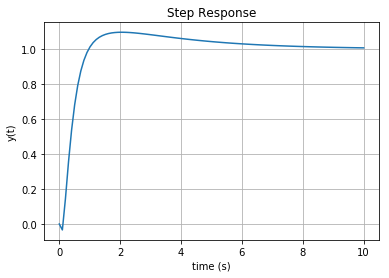

In [22]:
t, y = step(T, T=linspace(0,10,100))
plot(y, t)
title("Step Response")
grid()
xlabel("time (s)")
ylabel("y(t)")

The frequency response and Nyquist plot for the loop transfer function are computed using the commands

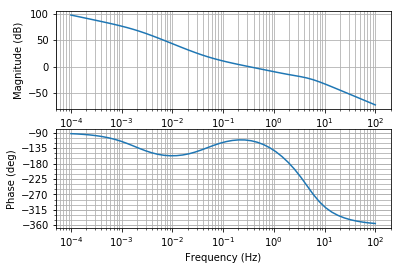

In [24]:
_ = bode(L)

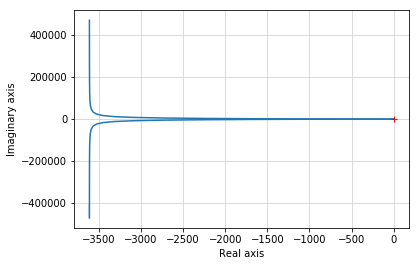

In [26]:
_ = nyquist(L, (0.0001, 1000))

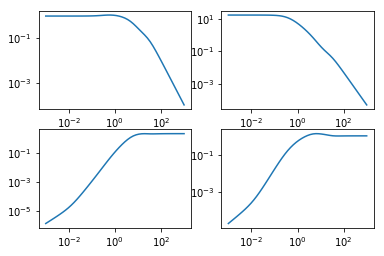

In [27]:
gangof4(Hi * Po, Co)